# Demo
This notebook is a detailed demo for people who are interested in further research on this project or who are trying to reproduce the results. Python3 is required for the code to run properly.
If you are more interested in the abstracted functions instead of detailed implementations, please go to `demo_notebook_clean.ipynb`.

## Config
To install the requirements, run the following code in the terminal. <br>

`pip3 install -r requirements.txt`

This command would install all dependencies required for this project.

## Import
First we need to import the required libraries

In [2]:
import json
import os
import time
import urllib
from pathlib import Path

import pandas as pd
import requests
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Constants Definition

Here the constants are defined to make the requests with the Pageview API.

In [3]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
# Assuming roughly 2ms latency on the API and network
API_LATENCY_ASSUMED = 0.002
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<uwnetid@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
PROJECT_ROOT_DIR = Path(os.getcwd()).absolute().parent
article_df = pd.read_csv(os.path.join(
    PROJECT_ROOT_DIR, 'data', 'data_raw', 'dinosaur_genera.cleaned.SEPT.2022.csv'))
ARTICLE_TITLES = article_df['name']
ARTICLE_TITLES[0] = '"Coelosaurus" antiquus'
ARTICLE_URLS = article_df['url']

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "20150101",
    "end":         "20221001"    # this is likely the wrong end date
}

Before we start anything with the data, we need to decide what is the start date and end date of this project. They should be in the format of "%Y%m%d%".

In [4]:
start_date = '20150701'
end_date = '20221001'

## Data Acquisition
To obtain the JSON files in `/data/data_clean/`, we need to process the files individually.
The following is a function used to collect response for a given article from a certain start date to a certain end date.

In [5]:
def request_pageviews_per_article(article_title=None, start_date=None,
                                  end_date=None,
                                  endpoint_url=API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params=API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers=REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title:
        return None

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ', '_'))
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url + endpoint_params.format(**request_template)

    # Update the dates if necessary
    if start_date:
        ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['start'] = start_date

    if end_date:
        ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['end'] = end_date

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

### Generate monthly desktop traffic data

For each article title, we try to get a response from the Pageview server and update to our own json. There is a chance that the response is empty/invalid. For those error responses, we collect them to `error_articles`.

In [6]:
monthly_desktop_json = {}
error_articles = {"titles": []}

for article_title in tqdm.tqdm(ARTICLE_TITLES):
    json_response = request_pageviews_per_article(article_title=article_title,
                                                    start_date=start_date, end_date=end_date)

    try:
        monthly_desktop_json.update({article_title: json_response['items']})
    except KeyError:
        print(f'{article_title} has error. Please check.')
        error_articles['titles'].append(article_title)

100%|██████████| 1423/1423 [03:05<00:00,  7.66it/s]


The error articles are as follows

In [7]:
error_articles

{'titles': []}

Then we save it to a JSON file in `/data/data_clean`.

In [8]:
# Creates output
if not os.path.exists(os.path.join(PROJECT_ROOT_DIR, 'data')):
    os.mkdir('data')

with open(os.path.join(PROJECT_ROOT_DIR, "data", "data_clean", f"dino_monthly_desktop_<start{start_date[:6]}>-<end{end_date[:6]}>.json"), "w") as f:
    json.dump(monthly_desktop_json, f, indent=4)

### Generate monthly mobile traffic data

Similar to desktop traffic data, we are collecting each article's monthly mobile access data. The API call accesses mobile-web and mobile-app individually, so we need to combine the view counts before adding to our own json file.

In [13]:
monthly_mobile_json = {}
error_articles = {"titles": []}

for article_title in tqdm.tqdm(ARTICLE_TITLES):
    mobile_req_params = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE.copy()

    # Mobile-app response
    mobile_req_params['access'] = 'mobile-app'
    app_json_response = request_pageviews_per_article(article_title=article_title,
                                                        start_date=start_date, end_date=end_date, request_template=mobile_req_params)

    # Mobile-web response
    mobile_req_params['access'] = 'mobile-web'
    web_json_response = request_pageviews_per_article(article_title=article_title,
                                                        start_date=start_date, end_date=end_date, request_template=mobile_req_params)

    try:
        # Combine the web and app results
        comb_json_response = [{
            'project': web['project'],
            'article': web['article'],
            'granularity': web['granularity'],
            'timestamp': web['timestamp'],
            'access': 'mobile',
            'agent': 'user',
            'views': web['views'] + app['views']
        } for web, app in zip(web_json_response['items'], app_json_response['items'])]

        # Add to result json
        monthly_mobile_json.update({article_title: comb_json_response})

    except KeyError:
        print(f'{article_title} has error. Please check.')
        error_articles['titles'].append(article_title)
        continue

100%|██████████| 1423/1423 [06:07<00:00,  3.87it/s]


Creates an output in `/data/data_clean`

In [14]:
# Creates output
if not os.path.exists(os.path.join(PROJECT_ROOT_DIR, 'data')):
    os.mkdir('data')

with open(os.path.join(PROJECT_ROOT_DIR, "data", "data_clean", f"dino_monthly_mobile_<start{start_date[:6]}>-<end{end_date[:6]}>.json"), "w") as f:
    json.dump(monthly_mobile_json, f, indent=4)

### Generate monthly cumulative access

We also need to collect all the monthly cumulative access counts for both desktop and mobile accesses for each title. To do this, we need to get three responses: mobile app, mobile web and desktop, and add them up for each month. We also need to accumulate the view counts before saving it to our own json file.

In [17]:
monthly_accumu_json = {}
error_articles = {"titles": []}

for article_title in tqdm.tqdm(ARTICLE_TITLES):
    mobile_req_params = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE.copy()

    # Mobile app response
    mobile_req_params['access'] = 'mobile-app'
    app_json_response = request_pageviews_per_article(article_title=article_title,
        start_date=start_date, end_date=end_date, request_template=mobile_req_params)

    # Mobile web response
    mobile_req_params['access'] = 'mobile-web'
    web_json_response = request_pageviews_per_article(article_title=article_title,
        start_date=start_date, end_date=end_date, request_template=mobile_req_params)

    # Desktop response
    desktop_json_response = request_pageviews_per_article(article_title=article_title,
        start_date=start_date, end_date=end_date, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)

    try:
        # Combine results from all three responses
        comb_json_response = [{
            'project': web['project'],
            'article': web['article'],
            'granularity': web['granularity'],
            'timestamp': web['timestamp'],
            'agent': 'user',
            'views': web['views'] + app['views'] + desktop['views']
        } for web, app, desktop in zip(web_json_response['items'], app_json_response['items'], desktop_json_response['items'])]

        # Accumulate the views
        for i, comb in enumerate(comb_json_response):
            if i > 0:
                prev_comb = comb_json_response[i - 1]
                comb['views'] += prev_comb['views']

        monthly_accumu_json.update({article_title: comb_json_response})
    except KeyError:
        print(f'{article_title} has error. Please check.')
        error_articles['titles'].append(article_title)

100%|██████████| 1423/1423 [12:27<00:00,  1.90it/s]


Creates output at `/data/data_clean`

In [18]:
# Creates output
if not os.path.exists(os.path.join(PROJECT_ROOT_DIR, 'data')):
    os.mkdir('data')

with open(os.path.join(PROJECT_ROOT_DIR, "data", "data_clean", f"dino_monthly_cumulative_<start{start_date[:6]}>-<end{end_date[:6]}>.json"), "w") as f:
    json.dump(monthly_accumu_json, f, indent=4)

## Data Visualization
After we have generated the json data files, we could use them to produce visualizations for further data analysis. The following three visualizations are created: <br>
1. Maximum Average and Minimum Average <br>
    This graph contains time series for articles with the highest average page requests and lowest average page requests for both desktop and mobile access. This is located in `img/max_min_avg.png`. <br>
2. Top 10 Peak Page Views <br>
    This graph contains time series for the top 10 article pages by peak page views over the entire time by access type. This is located in `img/top10peak.png`. <br>
3. Fewest Months of Data <br>
    This graph shows the pages with the fewest months of available data. Some of them have only one month of data. The created graph is located in `img/top10peak.png`.<br>

### Reading in the data

In [19]:
# Load the data into dict
with open(os.path.join(PROJECT_ROOT_DIR, 'data', 'data_clean', 'dino_monthly_desktop_<start201501>-<end202210>.json'), 'r') as f:
    desktop_dict = json.load(f)

with open(os.path.join(PROJECT_ROOT_DIR, 'data', 'data_clean', 'dino_monthly_mobile_<start201501>-<end202210>.json'), 'r') as f:
    mobile_dict = json.load(f)


# Rearrange the data and filter out unneeded attributes. Keep only views and time
desktop_views = {
    article: {
        'views':[month['views'] for month in desktop_dict[article]],
        'months': [month['timestamp'][:-2] for month in desktop_dict[article]] 
    } for article in desktop_dict
}

mobile_views = {
    article: {
        'views':[month['views'] for month in mobile_dict[article]],
        'months': [month['timestamp'][:8] for month in mobile_dict[article]] 
    } for article in mobile_dict
}

### Maximum Average and Minimum Average

First we need to determine which article has the max and min average monthly counts for desktop access and mobile access. The max, min are stored in tuple format, where `tuple[0]` is the article name, `tuple[1]` is the average count, and `tuple[2]` is a list containing the timespan of this article.

In [20]:
# Initialize max and min for desktop and mobile access
max_desk = ('', -float('inf'), [])
min_desk = ('', float('inf'), [])
max_mob = ('', -float('inf'), [])
min_mob = ('', float('inf'), [])

# Get the max and min for desktop
for article, param in desktop_views.items():
    article_avg = np.mean(param['views'])
    months = param['months']
    if article_avg > max_desk[1]:
        max_desk = (article, article_avg, months)
    if article_avg < min_desk[1]:
        min_desk = (article, article_avg, months)

# Get the max and min for mobile
for article, param in mobile_views.items():
    article_avg = np.mean(param['views'])
    months = param['months']
    if article_avg > max_mob[1]:
        max_mob = (article, article_avg, months)
    if article_avg < min_mob[1]:
        min_mob = (article, article_avg, months)

We then plot the graph with Seaborn

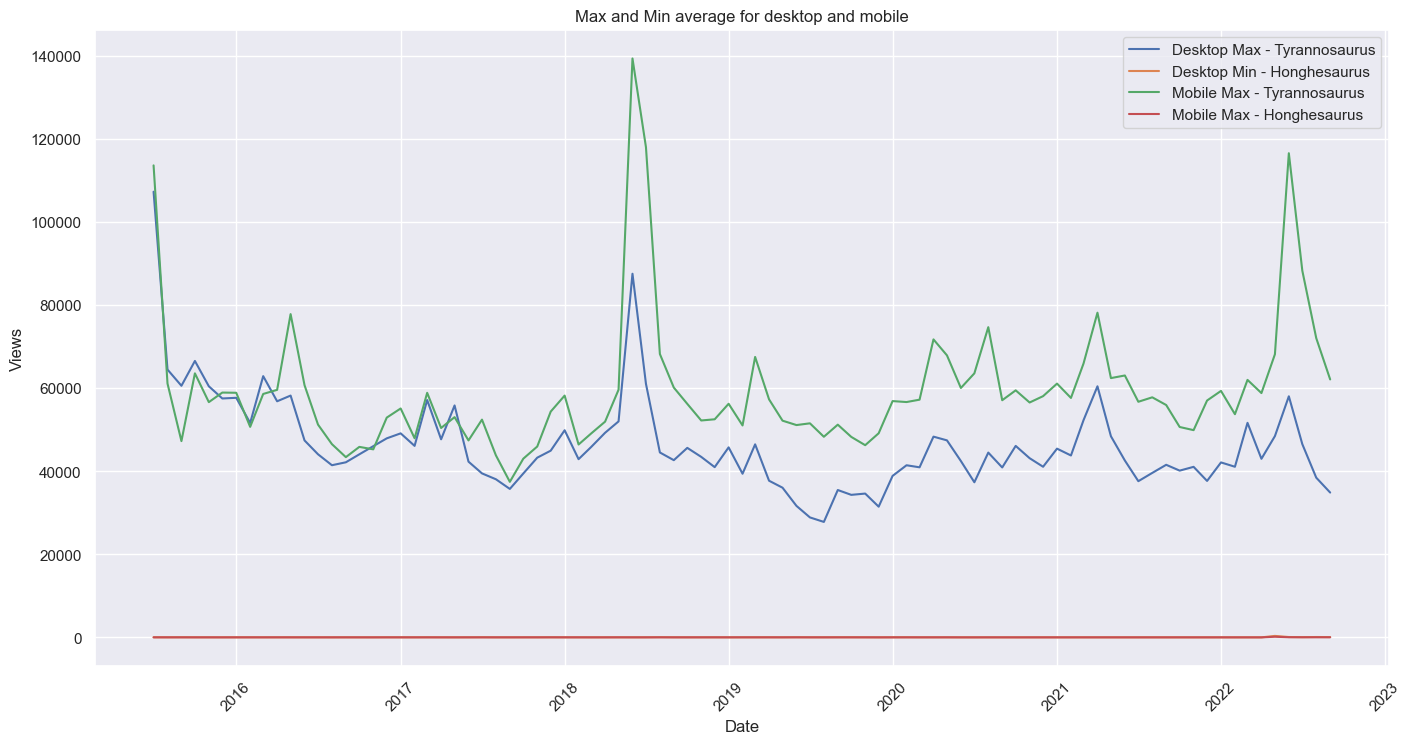

In [21]:
sns.set(rc={'figure.figsize':(16.7,8.27)})

sns.lineplot(x=pd.to_datetime(max_desk[2], format='%Y%m%d'), y=desktop_views[max_desk[0]]['views'], label=f'Desktop Max - {max_desk[0]}')
sns.lineplot(x=pd.to_datetime(min_desk[2], format='%Y%m%d'), y=desktop_views[min_desk[0]]['views'], label=f'Desktop Min - {min_desk[0]}')
sns.lineplot(x=pd.to_datetime(max_mob[2], format='%Y%m%d'), y=mobile_views[max_mob[0]]['views'], label=f'Mobile Max - {max_mob[0]}')
sns.lineplot(x=pd.to_datetime(min_mob[2], format='%Y%m%d'), y=mobile_views[min_mob[0]]['views'], label=f'Mobile Max - {min_mob[0]}')

# Graph config
plt.xticks(rotation=45)
plt.title("Max and Min average for desktop and mobile")
plt.xlabel('Date')
plt.ylabel('Views')
plt.show()

### Top 10 Peak Page Views

For this graph, we need to get a peak value for all of the articles first, sort the peak views and get the top 10 for both desktop and mobile access.

In [22]:
# Modifying the data structure: find the peak value for each article
desktop_max = {
    article: {
        'views': desktop_views[article]['views'][np.argmax(desktop_views[article]['views'])]
    } for article in desktop_dict
}

mobile_max = {
    article: {
        'views': mobile_views[article]['views'][np.argmax(mobile_views[article]['views'])]
    } for article in mobile_dict
}

Sort the articles based on the peak value, then select the top 10

In [23]:
top_10_desktop = [(article, desktop_max[article]['views']) for article in desktop_max]
top_10_mobile = [(article, mobile_max[article]['views']) for article in mobile_max]

top_10_desktop = sorted(top_10_desktop, key=lambda x:x[1], reverse=True)[:10]
top_10_mobile = sorted(top_10_mobile, key=lambda x:x[1], reverse=True)[:10]

Plot the graph

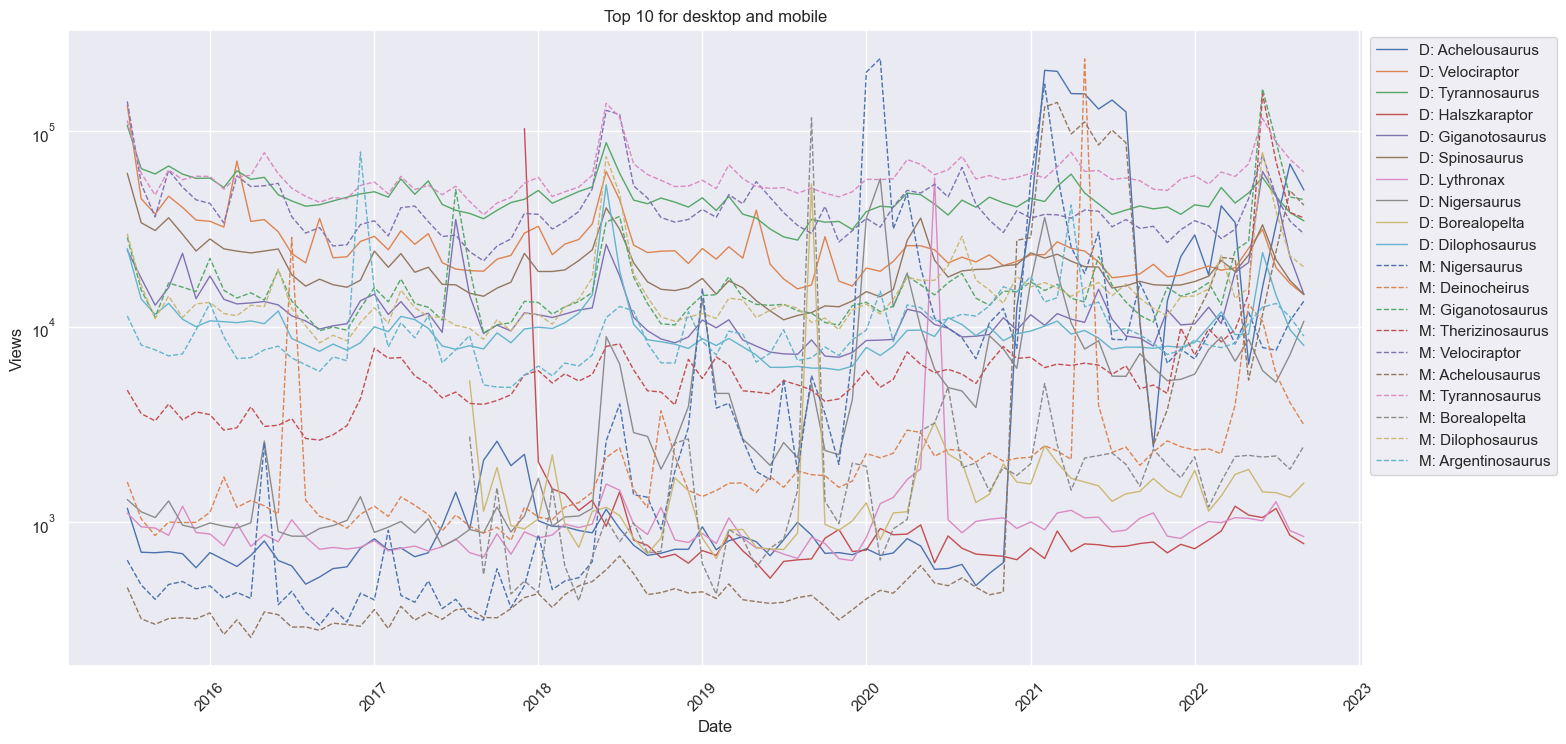

In [25]:
# Plot the graph
sns.set(rc={'figure.figsize':(16.7,8.27)})
for article, _ in top_10_desktop:
    ax = sns.lineplot(x=pd.to_datetime(desktop_views[article]['months'], format='%Y%m%d'), y=desktop_views[article]['views'], linewidth=1, label=f'D: {article}')

for article, _ in top_10_mobile:
    ax = sns.lineplot(x=pd.to_datetime(mobile_views[article]['months'], format='%Y%m%d'), y=mobile_views[article]['views'], linewidth=1, linestyle='--', label=f'M: {article}')

# Graph config
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Top 10 for desktop and mobile")
plt.xlabel('Date')
plt.ylabel('Views')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

### Fewest Months of Data 
This visualization finds the top 10 articles with the least amount of data in terms of fewest months. First we need to get the length of the vews from the data files.

In [26]:
# Select the the articles and length of views from the data files
desktop_len = [(article, len(desktop_views[article]['views'])) for article in desktop_dict]
mobile_len = [(article, len(mobile_views[article]['views'])) for article in mobile_dict]

Then sort the articles by length ascending and select the first ten

In [27]:
min_10_desktop_len = sorted(desktop_len, key=lambda x:x[1])[:10]
min_10_mobile_len = sorted(mobile_len, key=lambda x:x[1])[:10]

Plot the graph: there would be 20 lines in total, ten for desktop access and ten for mobile access. Most of them have only one month of access.

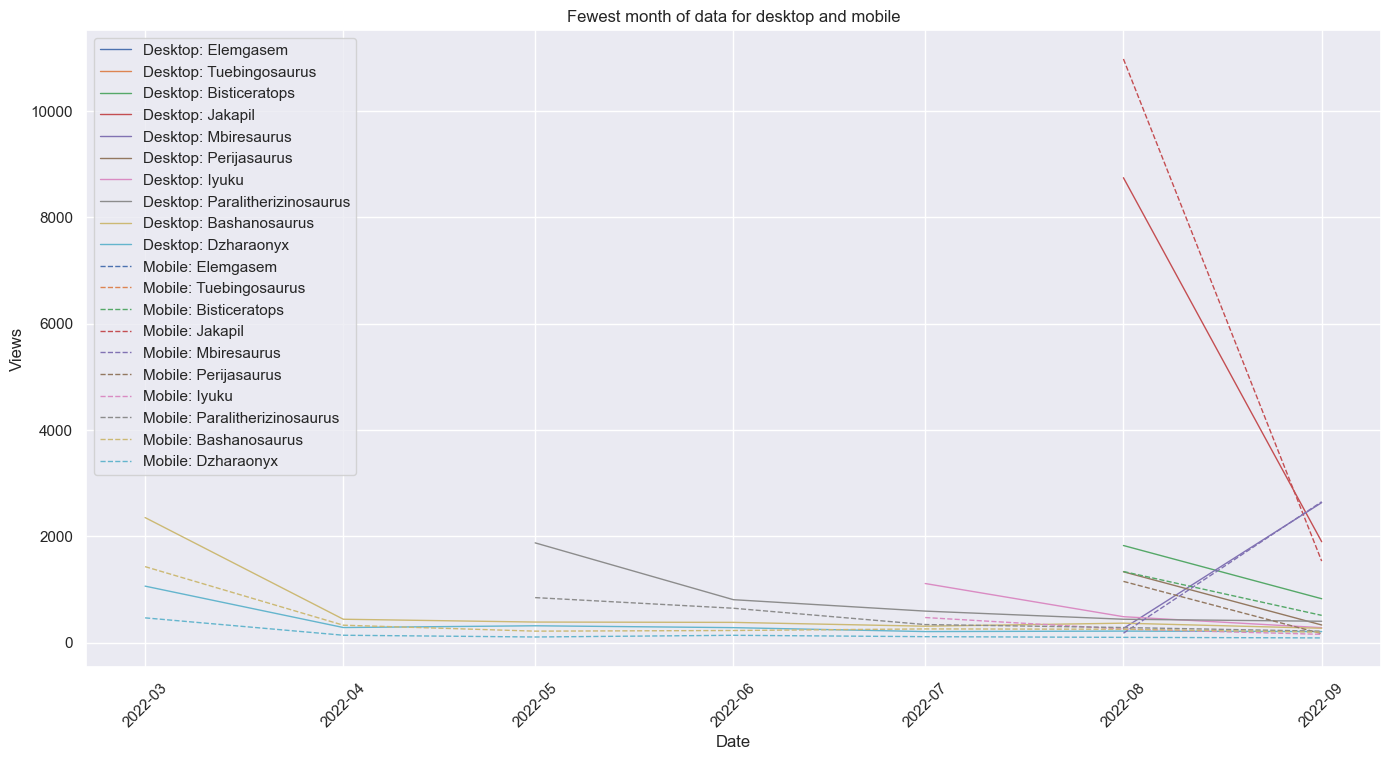

In [28]:
# Plot the graph
sns.set(rc={'figure.figsize':(16.7,8.27)})
for article, _ in min_10_desktop_len:
    sns.lineplot(x=pd.to_datetime(desktop_views[article]['months'], format='%Y%m%d'), y=desktop_views[article]['views'], linewidth=1, label=f'Desktop: {article}')

for article, _ in min_10_mobile_len:
    sns.lineplot(x=pd.to_datetime(mobile_views[article]['months'], format='%Y%m%d'), y=mobile_views[article]['views'], linewidth=1, linestyle='--', label=f'Mobile: {article}')

# Graph config
plt.xticks(rotation=45)
plt.title("Fewest month of data for desktop and mobile")
plt.xlabel('Date')
plt.ylabel('Views')
plt.show()